In [2]:
import sys

# Simple Trading Rule

In [3]:
# from sysdata.csv.csv_sim_futures_data import csvFuturesData
from sysdata.csv.csv_sim_futures_data import csvFuturesSimData




import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sysdata.csv.csv_sim_futures_data import csvFuturesSimData

Work up a minimum example of a trend following system

Let's get some data

We can get data from various places; however for now we're going to use
prepackaged 'legacy' data stored in csv files

In [5]:
data = csvFuturesSimData()
data

csvFuturesSimData for 38 instruments

We get stuff out of data with methods

In [6]:
data

csvFuturesSimData for 38 instruments

In [7]:
print(data.get_instrument_list())
print(data.get_raw_price("EDOLLAR").tail(5))

['KR10', 'WHEAT', 'US20', 'CAC', 'BTP', 'GAS_US', 'PALLAD', 'US5', 'BOBL', 'NZD', 'LIVECOW', 'SMI', 'SP500', 'SHATZ', 'SOYBEAN', 'LEANHOG', 'AEX', 'CORN', 'OAT', 'PLAT', 'CRUDE_W', 'KOSPI', 'GOLD', 'NASDAQ', 'KR3', 'GBP', 'COPPER', 'AUD', 'VIX', 'MXP', 'US2', 'BUND', 'EDOLLAR', 'US10', 'V2X', 'EUROSTX', 'JPY', 'EUR']
index
2019-11-11 23:00:00        NaN
2019-11-12 23:00:00        NaN
2019-11-13 23:00:00        NaN
2019-11-14 19:36:14    98.4325
2019-11-14 23:00:00    98.4250
Name: price, dtype: float64


data can also behave in a dict like manner (though it's not a dict)

In [8]:
data['SP500']

index
1997-09-10 00:00:00   -1735.9525
1997-09-11 00:00:00   -1742.9525
1997-09-12 00:00:00   -1726.9525
1997-09-15 00:00:00   -1728.9525
1997-09-16 00:00:00   -1704.9525
                         ...    
2020-03-17 16:27:45    2498.8750
2020-03-17 17:28:02    2445.3750
2020-03-17 23:00:00    2485.5000
2020-03-18 14:02:49    2410.3750
2020-03-18 15:03:18    2390.7500
Name: price, Length: 9386, dtype: float64

In [9]:
data.keys()

['KR10',
 'WHEAT',
 'US20',
 'CAC',
 'BTP',
 'GAS_US',
 'PALLAD',
 'US5',
 'BOBL',
 'NZD',
 'LIVECOW',
 'SMI',
 'SP500',
 'SHATZ',
 'SOYBEAN',
 'LEANHOG',
 'AEX',
 'CORN',
 'OAT',
 'PLAT',
 'CRUDE_W',
 'KOSPI',
 'GOLD',
 'NASDAQ',
 'KR3',
 'GBP',
 'COPPER',
 'AUD',
 'VIX',
 'MXP',
 'US2',
 'BUND',
 'EDOLLAR',
 'US10',
 'V2X',
 'EUROSTX',
 'JPY',
 'EUR']

... however this will only access prices
(note these prices have already been backadjusted for rolls)

We have extra futures data here

In [10]:
print(data['GBP'].tail()),
print(data['AUD'].tail())
print(data['VIX'].tail())
print(data['BUND'].tail())
print(data['V2X'].tail())
print(data['EUROSTX'].tail())

index
2020-03-18 10:21:02    1.20520
2020-03-18 11:21:44    1.19475
2020-03-18 12:23:01    1.18940
2020-03-18 13:25:15    1.18730
2020-03-18 14:38:02    1.18320
Name: price, dtype: float64
index
2020-03-17 15:48:06    0.60080
2020-03-17 16:53:58    0.59715
2020-03-17 17:54:41    0.59825
2020-03-17 18:55:58    0.59870
2020-03-17 23:00:00    0.59940
Name: price, dtype: float64
index
2020-03-17 15:45:27    44.700
2020-03-17 16:52:01    46.075
2020-03-17 17:52:22    45.375
2020-03-17 18:54:00    45.850
2020-03-17 23:00:00    48.700
Name: price, dtype: float64
index
2020-03-18 10:36:53    169.670
2020-03-18 11:37:10    169.800
2020-03-18 12:41:47    169.435
2020-03-18 13:43:13    169.415
2020-03-18 14:56:04    169.405
Name: price, dtype: float64
index
2020-03-18 10:00:43    48.825
2020-03-18 11:01:01    49.750
2020-03-18 12:13:54    49.925
2020-03-18 13:16:17    50.675
2020-03-18 14:29:15    50.150
Name: price, dtype: float64
index
2020-03-18 12:10:09    2340.5
2020-03-18 13:12:16    2336.5

In [11]:
data.get_instrument_raw_carry_data("EDOLLAR").tail(6)

,PRICE,CARRY,PRICE_CONTRACT,CARRY_CONTRACT
index,,,,
2020-03-17 19:31:30,99.1925,NaN,202303,202212
2020-03-17 23:00:00,99.2100,99.24,202303,202212
2020-03-18 12:00:11,99.1675,NaN,202303,202212
2020-03-18 13:00:44,99.1450,NaN,202303,202212
2020-03-18 14:04:36,99.1725,NaN,202303,202212
2020-03-18 15:12:40,99.1950,NaN,202303,202212


Technical note: csvFuturesData inherits from FuturesData which itself inherits
from Data
The chain is 'data specific' <- 'asset class specific' <- 'generic'

So there are also

In principal there could be an equities data

Let's create a simple trading rule

No capping or scaling

In [12]:
import pandas as pd
from syscore.algos import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading fule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # http://qoppac.blogspot.co.uk/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


Try it out

(this isn't properly scaled at this stage of course)


In [13]:
instrument_code = 'EUROSTX'
price = data.daily_prices(instrument_code)
ewmac = calc_ewmac_forecast(price, 32, 128)
ewmac.columns = ['forecast']
ewmac.tail(5)

index
2020-03-12   -1.376257
2020-03-13   -1.710991
2020-03-16   -2.049680
2020-03-17   -2.422312
2020-03-18   -2.798166
Freq: B, dtype: float64

Text(0.5, 0, 'Date')

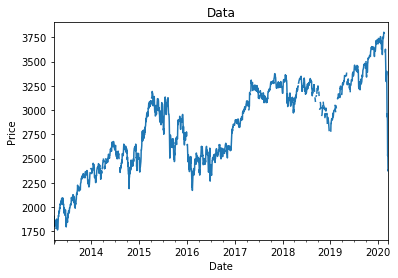

In [14]:
price.plot()
plt.title('Data')
plt.ylabel('Price')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

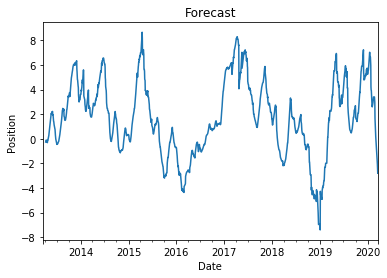

In [15]:
ewmac.plot();
plt.title('Forecast')
plt.ylabel('Position')
plt.xlabel('Date')


Did we make money?


In [16]:
accountCurve?

Object `accountCurve` not found.


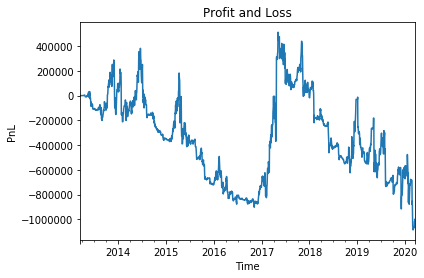

In [17]:
from syscore.accounting import accountCurve
account = accountCurve(price, forecast=ewmac)
account.curve().plot();
plt.title('Profit and Loss')
plt.ylabel('PnL')
plt.xlabel('Time');

In [18]:
account.percent().stats()

[[('min', '-3.137'),
  ('max', '5.219'),
  ('median', '0'),
  ('mean', '-0.005473'),
  ('std', '0.3902'),
  ('skew', '0.1698'),
  ('ann_mean', '-1.401'),
  ('ann_std', '6.243'),
  ('sharpe', '-0.2244'),
  ('sortino', '-0.2431'),
  ('avg_drawdown', '-7.271'),
  ('time_in_drawdown', '0.9759'),
  ('calmar', '-0.08771'),
  ('avg_return_to_drawdown', '-0.1927'),
  ('avg_loss', '-0.2471'),
  ('avg_gain', '0.222'),
  ('gaintolossratio', '0.8984'),
  ('profitfactor', '0.9492'),
  ('hitrate', '0.5137'),
  ('t_stat', '-0.5996'),
  ('p_value', '0.5489')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent', 'cumulative'])]